In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [119]:
train1 = pd.read_csv("data/train_1.csv")
train1.fillna(0,inplace=True)
train1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


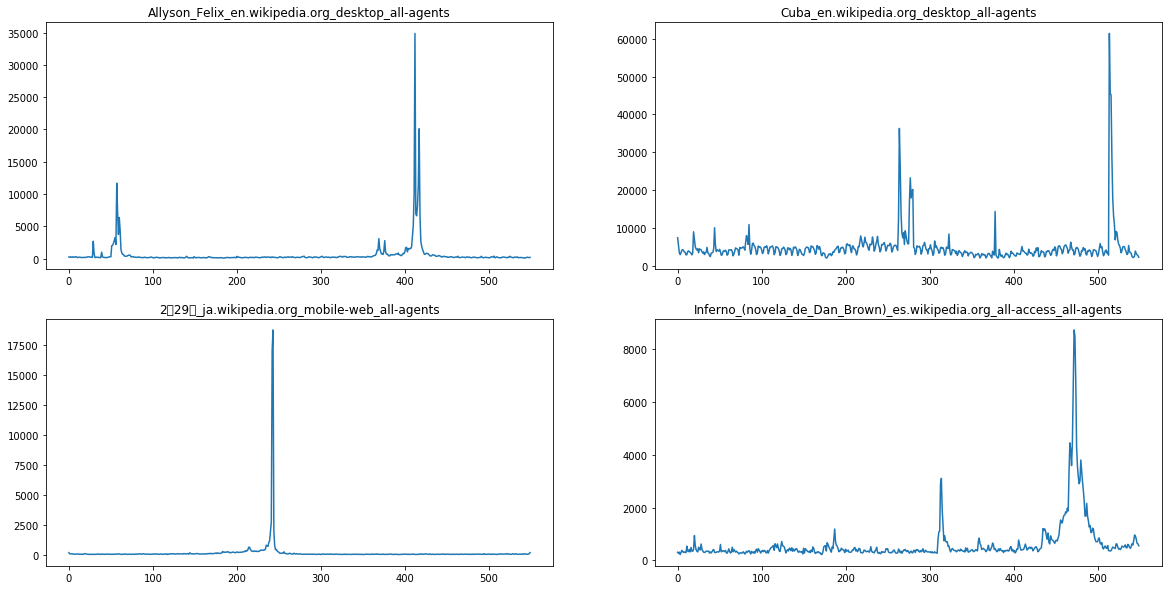

In [120]:
import random
train1.info()
days = range(train1.shape[1]-1)
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sample = random.randint(0,train1.shape[0])
    data = train1.iloc[sample,1:]
    plt.plot(days,data)
    plt.title(train1.iloc[sample,0])

plt.show()

In [121]:
import re

def extract_meta(page):
    parts = page.split("_")
    [project,access,agent] = parts[-3:]
    name = " ".join(parts[0:-3])
    match_lang = re.search("([a-z][a-z])\.wikipedia\.org",project)
    lang = match_lang.group(1) if match_lang else 'na'
    return [name,lang,access,agent]

In [122]:
train1['name'],  train1['lang'], train1['access'], train1['agent'] = zip(*train1['Page'].apply(extract_meta))
train1 = train1[['Page', 'name', 'lang', 'access', 'agent'] + [c for c in train1 if c not in ['Page', 'name', 'lang', 'access', 'agent']]]

In [123]:
train1.head()

,Page,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access,spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access,spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access,spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access,spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52 Hz I Love You,zh,all-access,spider,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [137]:
train_by_lang = {}

for lang in train1['lang'].unique().tolist():
    print(lang)
    train_by_lang[lang] = train1[train1['lang'] == lang]
    train_by_lang[lang].info()
    
def plot_for_lang(index,lang):
    title = train_by_lang[lang].iloc[index,0]
    data = train_by_lang[lang].iloc[index,5:]
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(len(data)),data)
    plt.title(title)
    plt.show()

zh
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17229 entries, 0 to 109449
Columns: 555 entries, Page to 2016-12-31
dtypes: float64(550), object(5)
memory usage: 73.1+ MB
fr
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17802 entries, 4310 to 131932
Columns: 555 entries, Page to 2016-12-31
dtypes: float64(550), object(5)
memory usage: 75.5+ MB
en
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24108 entries, 8357 to 113950
Columns: 555 entries, Page to 2016-12-31
dtypes: float64(550), object(5)
memory usage: 102.3+ MB
na
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17855 entries, 13332 to 84734
Columns: 555 entries, Page to 2016-12-31
dtypes: float64(550), object(5)
memory usage: 75.7+ MB
ru
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15022 entries, 15882 to 127432
Columns: 555 entries, Page to 2016-12-31
dtypes: float64(550), object(5)
memory usage: 63.7+ MB
de
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18547 entries, 46371 to 141525
Columns: 555 entries, 

fr 12232


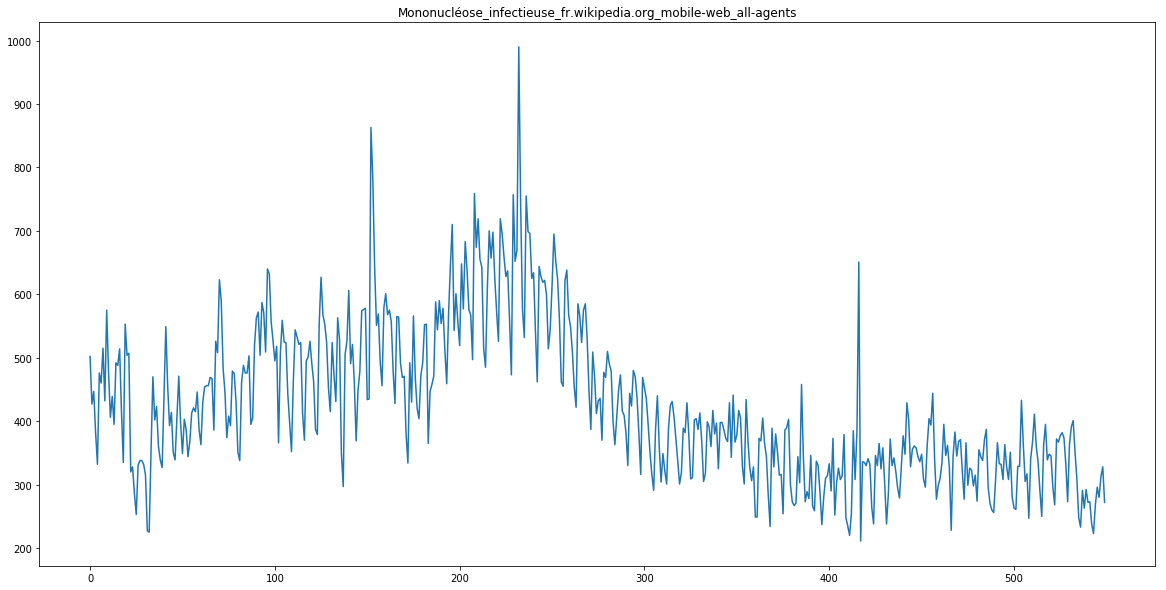

In [224]:
import random
key = random.choice(list(train_by_lang.keys()))
index = random.randint(0,train_by_lang[key].shape[0])
print(key,index)
plot_for_lang(index,key)

In [225]:
sums_by_lang = {}
for key in train_by_lang:
    sums_by_lang[key] = train_by_lang[key].iloc[:,5:].sum(axis=0)

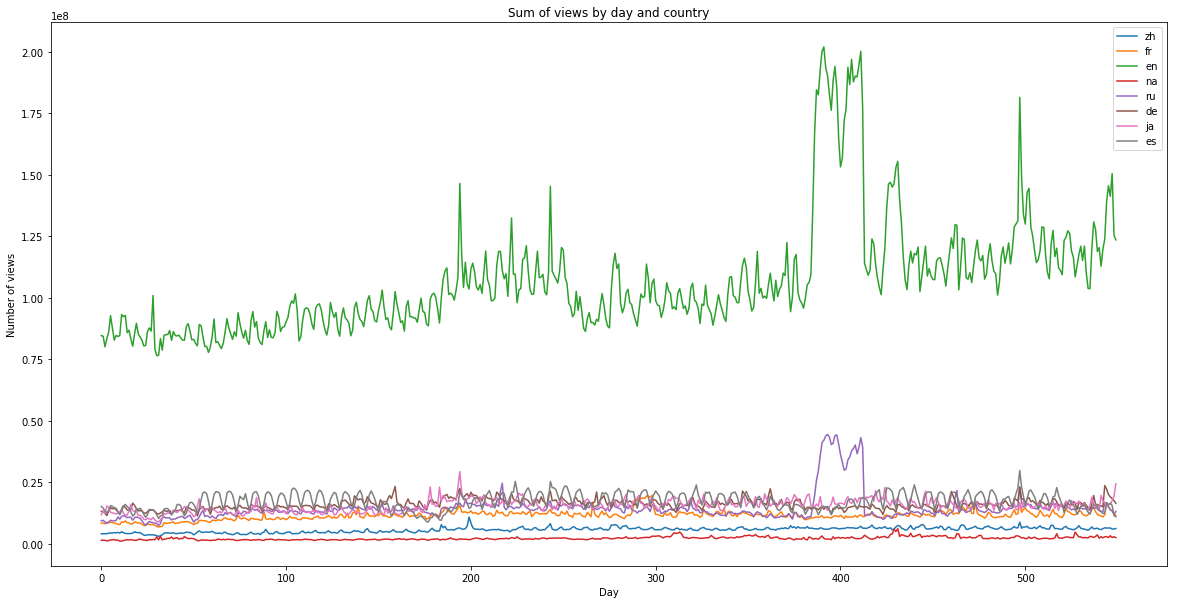

In [226]:
plt.figure(figsize=(20,10))

for key in sums_by_lang:
    plt.plot(range(sums_by_lang[key].shape[0]), sums_by_lang[key],label=key)

plt.legend()
plt.title("Sum of views by day and country")
plt.ylabel("Number of views")
plt.xlabel("Day")
plt.show()

## Testing with fbProphet

In [227]:
from fbprophet import Prophet
full_set = sums_by_lang['en']
full_set = pd.DataFrame({'ds': full_set.index.values, 'y': full_set.values})
train = full_set.iloc[:365,:]
test = full_set.iloc[365:,:]

/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


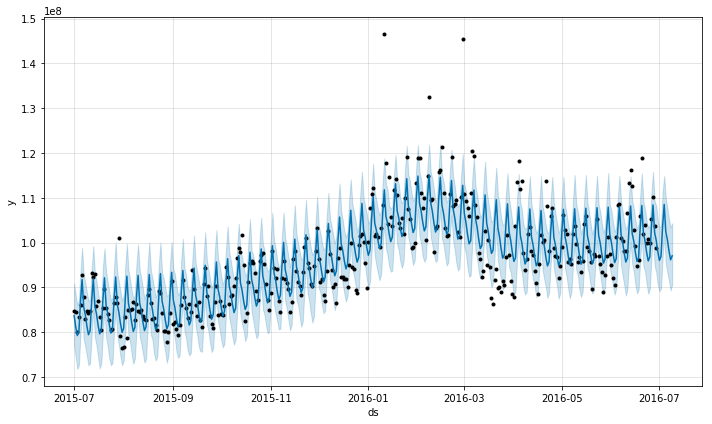

In [228]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
fig = m.plot(forecast)

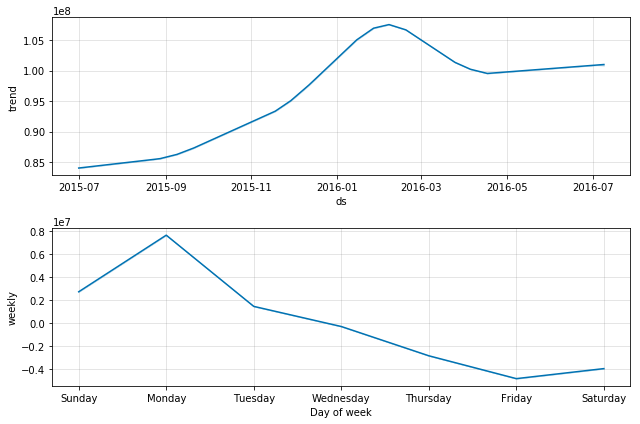

In [229]:
fig2 = m.plot_components(forecast)

## Testing ARIMA models

In [234]:
from statsmodels.tsa.arima_model import ARIMA
import sys

# de 72 is not bad
# na 12127
# es 1508
# fr 904
# na 9413
# en 1276
# en 23897

lang = 'na'
index = 12127
full_set = train_by_lang[lang].iloc[index,5:]
full_set = pd.DataFrame(full_set)
full_set = full_set.values
training_size = 450
train = full_set[:training_size]
test = full_set[training_size:]

history = [x for x in train]
prediction = []


for timepoint in range(len(test)):
    y =  test[timepoint]
    #forcast value
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    y_hat = output[0]
    print(f"{timepoint + 1}/{len(test)}",end='\r')
    #add it in the list
    prediction.append(y_hat)
    history.append(y_hat)

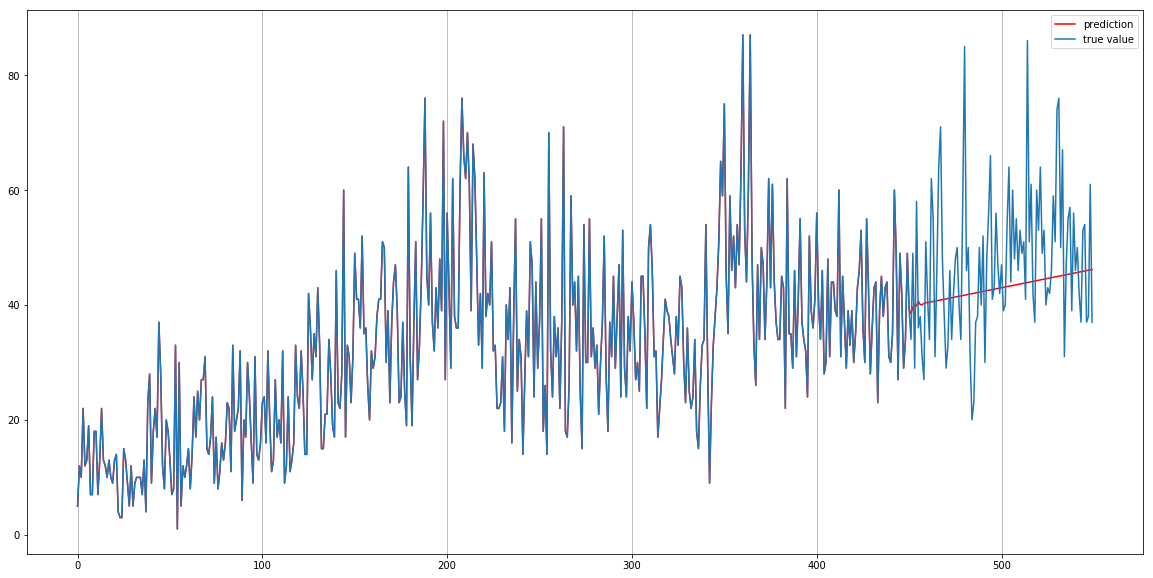

In [235]:
plt.figure(figsize=(20,10))
plot_prediction = [x for x in train] + prediction
plt.plot(plot_prediction, color='red', label='prediction')
plt.plot(full_set, label='true value')
# plt.xticks(ticks=np.arange(0,len(full_set),10))
plt.grid(axis='x',which='major')
plt.legend()
plt.show()

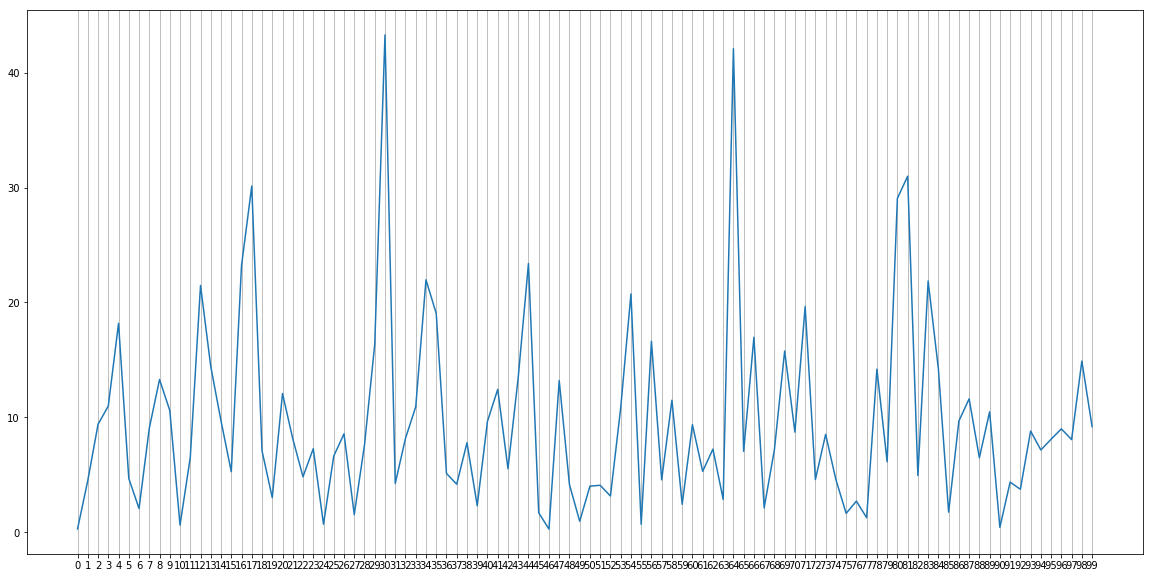

In [236]:
test_np = np.array(test)
pred_np = np.array(prediction)
absolute_diff = np.abs(test_np-pred_np)

plt.figure(figsize=(20,10))
plt.plot(absolute_diff)
plt.xticks(ticks=np.arange(0,len(test)))
plt.grid(axis='x',which='major')
plt.show()

In [237]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape(test_np, pred_np)

20.705927924198004